In [1]:
## Import the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

### Level 1

In [2]:
df= pd.read_csv("Fraud_Detection.csv")
print(df.shape)

(99776, 31)


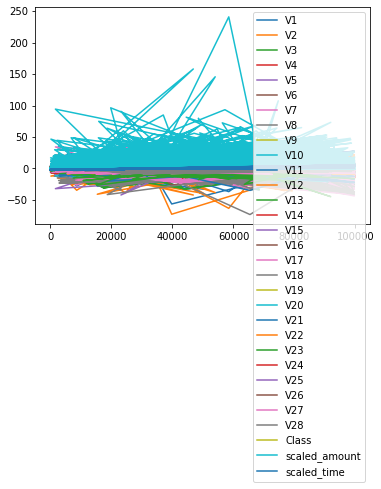

In [58]:
df.plot()

In [3]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
5,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
6,4,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
8,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
9,9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [57]:
df.Class.value_counts(normalize=True)

0    0.995069
1    0.004931
Name: Class, dtype: float64

- As mentioned in the problem statement and description, all attributes except for Time and Amount are scaled. So we need to scale the time and amount

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler() #(x-mean)/sd
rob_scaler = RobustScaler() #(x-median)/IQR

In [5]:
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

- Understanding data

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.51 % of the dataset
Frauds 0.49 % of the dataset


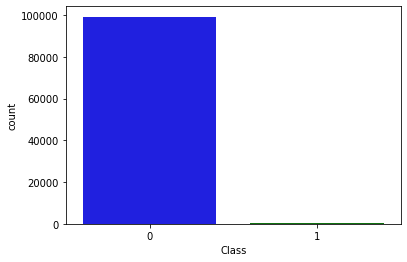

In [7]:
## A visual representation of the above information
sns.countplot('Class',data=df,palette=['blue','green'])

In [8]:
df.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
count,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,...,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000
mean,-0.270695,-0.024058,0.657125,0.173522,-0.283754,0.091063,-0.121257,0.052796,-0.052008,-0.037262,...,-0.108665,-0.036607,0.008733,0.131621,0.026571,0.000296,0.002010,0.004931,0.882000,-0.077924
std,1.890413,1.678539,1.406177,1.372090,1.379589,1.304693,1.299613,1.268675,1.133966,1.136929,...,0.641080,0.638218,0.595000,0.442029,0.494770,0.400861,0.325992,0.070048,3.253856,0.783361
min,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,-0.322941,-1.982150
25%,-1.031193,-0.597659,0.172367,-0.708895,-0.900604,-0.650199,-0.602878,-0.137719,-0.702465,-0.499784,...,-0.531342,-0.176572,-0.324092,-0.132378,-0.325209,-0.062601,-0.005376,0.000000,-0.230514,-0.483757
50%,-0.262837,0.079598,0.750652,0.196889,-0.314849,-0.158707,-0.070383,0.074152,-0.120310,-0.095873,...,-0.083665,-0.049238,0.064647,0.169859,-0.070415,0.009919,0.023352,0.000000,0.000000,0.000000
75%,1.152963,0.740262,1.374722,1.039248,0.250214,0.485321,0.414467,0.361241,0.557531,0.437705,...,0.309041,0.081874,0.406041,0.419740,0.300823,0.083486,0.076950,0.000000,0.769486,0.516243
max,2.132386,22.057729,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,13.249433,...,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,1.000000,240.950288,5.648134


In [9]:
scores = pd.DataFrame(columns=['Model', 'Train_F1_Score', 
                               'Test_F1_Score'])

def get_metrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):
    train_f1score   = f1_score(train_actual, train_predicted, average="weighted")
    test_f1score    = f1_score(test_actual, test_predicted, average="weighted")

    dataframe       = dataframe.append(pd.Series([model_description, train_f1score,
                                                  test_f1score],
                                                 index=scores.columns ), 
                                       ignore_index=True)

    return(dataframe)

In [10]:
scores

,Model,Train_F1_Score,Test_F1_Score


In [11]:
## Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
classifiers={'DT': DecisionTreeClassifier(),
'KNN': KNeighborsClassifier(),
'RF': RandomForestClassifier(),
'GBM':GradientBoostingClassifier()}


In [13]:
## Making a single train test split and applying multiple models
X = df.drop('Class', axis=1)
y = df['Class']


# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [56]:
%%time
from sklearn.metrics import confusion_matrix
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred_train= classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)
    print(classifier.__class__.__name__)
    print("----------------------------------------")
    print("Train Report")
    print(classification_report(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print("\n")
    print("Test Report")
    print(classification_report(y_test, y_pred_test))
    print(confusion_matrix(y_test, y_pred_test))
    print("\n")
    scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, classifier.__class__.__name__, scores)

RandomForestClassifier
----------------------------------------
Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79416
           1       1.00      1.00      1.00       404

    accuracy                           1.00     79820
   macro avg       1.00      1.00      1.00     79820
weighted avg       1.00      1.00      1.00     79820

[[79416     0]
 [    0   404]]


Test Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19868
           1       0.98      0.92      0.95        88

    accuracy                           1.00     19956
   macro avg       0.99      0.96      0.97     19956
weighted avg       1.00      1.00      1.00     19956

[[19866     2]
 [    7    81]]


KNeighborsClassifier
----------------------------------------
Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79416
       

In [15]:
scores

,Model,Train_F1_Score,Test_F1_Score
0,DecisionTreeClassifier,1.000000,0.998910
1,KNeighborsClassifier,0.999128,0.998613
2,RandomForestClassifier,1.000000,0.999390
3,GradientBoostingClassifier,0.999740,0.999011


### Level 2

In [16]:
AtrMedian = df.median().reset_index()
AtrMedian

,index,0
0,V1,-0.262837
1,V2,0.079598
2,V3,0.750652
3,V4,0.196889
4,V5,-0.314849
5,V6,-0.158707
6,V7,-0.070383
7,V8,0.074152
8,V9,-0.120310
9,V10,-0.095873


In [17]:
pd.options.display.max_columns = 999

In [18]:
ClassLevelMedian = df.groupby(['Class']).median().reset_index()
ClassLevelMedian

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,0,-0.256258,0.075790,0.756234,0.188732,-0.312874,-0.155814,-0.067831,0.073412,-0.116305,-0.093690,0.177925,0.114471,-0.007628,0.07992,0.300030,0.068608,-0.000202,-0.085559,-0.027319,-0.024729,-0.058015,-0.084088,-0.049193,0.065023,0.170118,-0.070763,0.009674,0.023283,0.001105,-0.001702
1,1,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.72972,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,-0.209402,1.402739


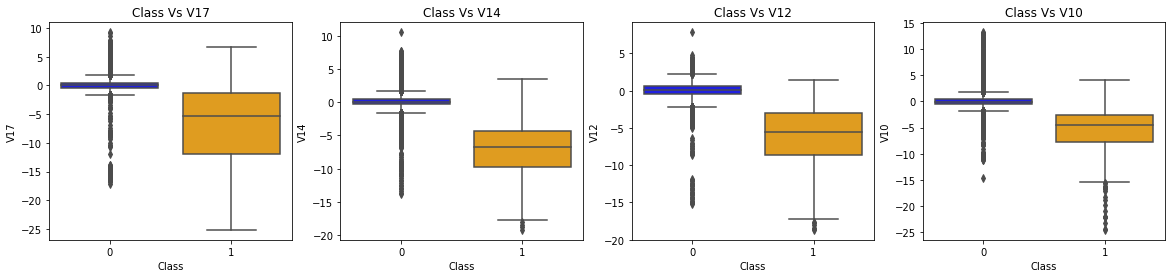

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

In [20]:
df1=df
fraud_out= df1['V12'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V12']=df1['V12'].clip(lower=lower)

fraud_out= df1['V14'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V14']=df1['V14'].clip(lower=lower)

fraud_out= df1['V17'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V17']=df1['V17'].clip(lower=lower)

fraud_out= df1['V10'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V10']=df1['V10'].clip(lower=lower)
         

In [21]:
X = df1.drop('Class', axis=1)
y = df1['Class']


# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [22]:
%%time
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred_train= classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)
    
    print(classification_report(y_train, y_pred_train))
    print("\n")
    print(classification_report(y_test, y_pred_test))
    print("\n")
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred_test))
    
    scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, classifier.__class__.__name__, scores)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69486
           1       1.00      1.00      1.00       357

    accuracy                           1.00     69843
   macro avg       1.00      1.00      1.00     69843
weighted avg       1.00      1.00      1.00     69843



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29798
           1       0.91      0.87      0.89       135

    accuracy                           1.00     29933
   macro avg       0.96      0.93      0.94     29933
weighted avg       1.00      1.00      1.00     29933



[[69486     0]
 [    0   357]]
[[29787    11]
 [   18   117]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69486
           1       0.97      0.86      0.91       357

    accuracy                           1.00     69843
   macro avg       0.99      0.93      0.96     69843
weighted

In [23]:
scores

,Model,Train_F1_Score,Test_F1_Score
0,DecisionTreeClassifier,1.000000,0.998910
1,KNeighborsClassifier,0.999128,0.998613
2,RandomForestClassifier,1.000000,0.999390
3,GradientBoostingClassifier,0.999740,0.999011
4,DecisionTreeClassifier,1.000000,0.999018
5,KNeighborsClassifier,0.999128,0.998613
6,RandomForestClassifier,1.000000,0.999357
7,GradientBoostingClassifier,0.999740,0.999011


### Level 3

In [24]:
## Undersampling the majority class to get it to equal proprotions
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:fraud_df.shape[0]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
58390,-0.399401,1.209003,1.160124,2.519368,0.899645,1.598197,-0.017581,-0.509283,-1.202492,0.802398,-0.640894,0.412057,0.970931,-0.119848,-0.643099,0.208882,-0.499896,0.674263,2.108301,0.008865,0.543956,-0.686570,-0.105763,-1.389587,-0.452752,0.059943,0.259406,0.150092,0,-0.136246,0.184096
15204,-19.179826,11.817922,-21.919174,6.086236,-14.708845,-4.308888,-15.357952,12.857165,-3.999861,-8.928656,5.849293,-8.261650,0.153829,-8.829359,0.008879,-7.070953,-13.629721,-4.958830,1.272091,1.572950,1.746802,-1.353149,-0.762965,0.117028,1.297994,-0.224825,1.621052,0.484614,1,0.904382,-0.792645
80229,-2.887045,-0.975865,3.013541,3.610743,-0.148851,1.960881,-1.757159,1.381946,0.306105,0.548581,0.325660,0.728990,-0.672744,-0.755071,-1.105298,-0.798299,1.188330,-0.002522,1.035036,-0.558083,0.012940,1.291879,1.118761,-0.232098,0.411343,0.649628,0.369283,-0.056428,0,-0.304284,0.633274
99508,-1.739334,-1.304655,0.314103,0.053740,-0.058696,0.071260,0.694862,-0.313270,-0.649377,0.517568,-1.356558,-0.238383,0.069579,-0.431690,-0.674724,-1.654162,-0.053961,0.520746,-1.554562,-1.463994,-0.665172,-0.632078,-0.421176,-0.400774,-0.001640,-0.495162,0.031633,0.066280,1,3.604885,1.057323
99640,-1.550273,1.088689,-2.393388,1.008733,-1.087562,-1.104602,-2.670503,0.147655,-0.978626,-3.514133,3.586042,-4.053358,0.862426,-5.765823,-0.507511,-4.921865,-9.567268,-2.772974,1.717095,0.327490,0.802316,1.037105,0.095815,-0.320191,-0.080731,0.091012,0.024928,-0.077820,1,-0.113539,3.199919


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


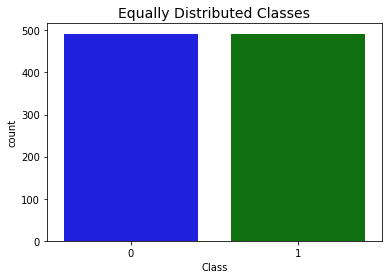

In [25]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts(normalize=True))



sns.countplot('Class', data=new_df, palette=['blue','green'])
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

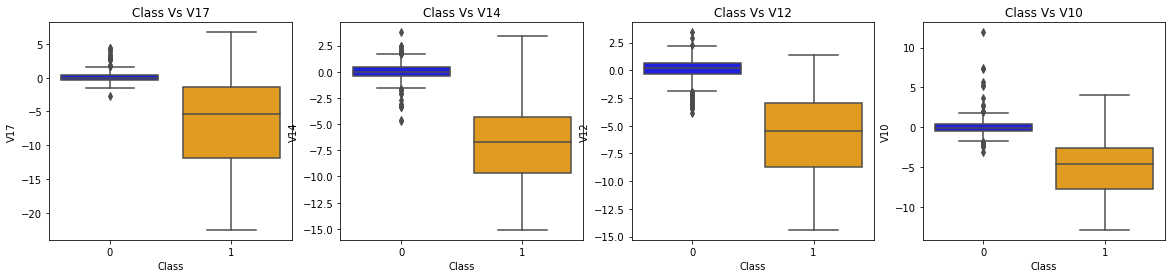

In [26]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

In [27]:
## There are some extreme values in the records, we can go with quantile clipping

fraud_out= new_df['V12'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V12']=new_df['V12'].clip(lower=lower,upper=upper)

fraud_out= new_df['V14'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V14']=new_df['V14'].clip(lower=lower,upper=upper)

fraud_out= new_df['V17'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V17']=new_df['V17'].clip(lower=lower,upper=upper)

fraud_out= new_df['V10'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V10']=new_df['V10'].clip(lower=lower,upper=upper)
         

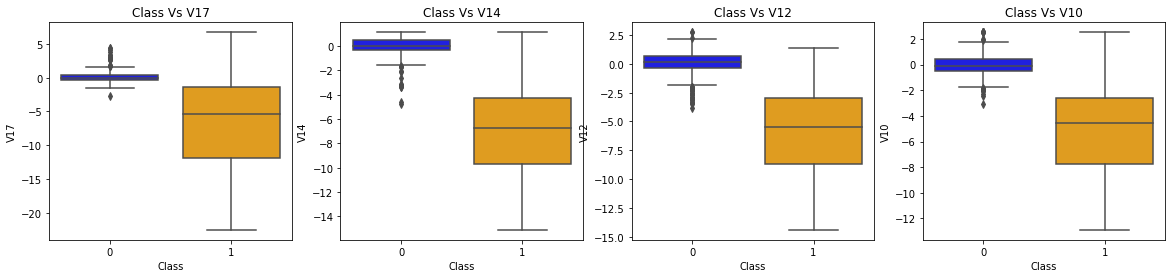

In [28]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

In [29]:
## Making a single train test split and applying multiple models
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
df_remain=df.drop(index=new_df.index)
print(df_remain.shape)

(98792, 31)


In [31]:
print(X_train.shape)
print(X_test.shape)
print(df_remain.shape)
print(y_train.shape)
print(y_test.shape)

(787, 30)
(197, 30)
(98792, 31)
(787,)
(197,)


In [32]:
df_remain.loc[:,'Class'].shape

(98792,)

In [33]:
# Let's implement simple classifiers
# Classifier Libraries
from sklearn.svm import SVC

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Gradboost": GradientBoostingClassifier()
}

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
%%time
class_metric={}
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5,scoring='f1')
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "%  F1 score")
    pred= classifier.predict(X_test)
    f1= f1_score(y_test,pred)
    class_metric[classifier.__class__.__name__]=f1
print("F1 Score on test data is: ",class_metric)

Classifiers:  RandomForestClassifier Has a training score of 97.0 %  F1 score
Classifiers:  KNeighborsClassifier Has a training score of 95.0 %  F1 score
Classifiers:  SVC Has a training score of 96.0 %  F1 score
Classifiers:  DecisionTreeClassifier Has a training score of 96.0 %  F1 score
Classifiers:  AdaBoostClassifier Has a training score of 97.0 %  F1 score
Classifiers:  GradientBoostingClassifier Has a training score of 97.0 %  F1 score
F1 Score on test data is:  {'RandomForestClassifier': 0.9622641509433962, 'KNeighborsClassifier': 0.9371980676328503, 'SVC': 0.9371980676328503, 'DecisionTreeClassifier': 0.9444444444444444, 'AdaBoostClassifier': 0.9532710280373831, 'GradientBoostingClassifier': 0.9719626168224299}
CPU times: user 4.38 s, sys: 18.3 ms, total: 4.4 s
Wall time: 4.4 s


In [36]:
### The result obtained is from the undersampled data. Lets check how the model performs on unseen data

test1= df.drop(X_train.index)
print(test1.shape)
print(test1.head(5))

(98989, 31)
             V1        V2        V3        V4        V5        V6        V7  \
62087  1.275341  0.228947 -0.002623  0.725416  0.213625  0.090323 -0.050774   
82006  1.204110  0.201846  0.247125  0.659175 -0.300867 -0.631273 -0.070489   
63981  1.142325 -1.170517  0.680685 -0.719162 -1.528441 -0.274904 -1.042925   
44683 -0.527976  0.965770  1.642678 -0.148833  0.098011 -0.195985  0.590102   
6047  -1.841893  0.730561  1.109791  0.891766  1.112475  1.158738 -0.315033   

             V8        V9       V10       V11       V12       V13       V14  \
62087  0.059963 -0.059091  0.180907  0.213579  0.295655 -0.271577  0.542818   
82006  0.004892  0.218047 -0.291939 -0.058651 -0.346229 -1.046362 -0.008816   
63981  0.184234 -0.391316  0.771640  0.771574 -1.119325 -1.849239  0.225732   
44683  0.174827 -0.752799 -0.209558  1.789607  1.059836  0.400738  0.279081   
6047  -0.012364  0.401643 -0.743097  0.318705 -2.089269  1.660433  1.640587   

            V15       V16       V17   

In [37]:
clf= GradientBoostingClassifier()
clf.fit(X_train, y_train)
test=test1.drop('Class',axis=1)
confusion_matrix(test1.loc[:,'Class'],clf.predict(test))

array([[97939,   940],
       [    6,   104]])

In [38]:
print(f1_score(test1.loc[:,'Class'],clf.predict(test)))
print(classification_report(test1.loc[:,'Class'],clf.predict(test)))

0.1802426343154246
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     98879
           1       0.10      0.95      0.18       110

    accuracy                           0.99     98989
   macro avg       0.55      0.97      0.59     98989
weighted avg       1.00      0.99      0.99     98989



We got a good result but this might not be reliable as we have undersampled the data before the model training 

In [39]:
### Model on entire dataset
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
clf.fit(X_train, y_train)
train_pred=clf.predict(X_train)
test_pred=clf.predict(X_test)

print(confusion_matrix(y_train,train_pred))
print("\n")
print(confusion_matrix(y_test,test_pred))



[[79416     0]
 [    1   403]]


[[19858    10]
 [    5    83]]


In [41]:
%%time
training_score = cross_val_score(clf, X_train, y_train, cv=5,scoring='f1')
print("Has a training score of", round(training_score.mean(), 2) * 100, "%  F1 score")

Has a training score of 90.0 %  F1 score
CPU times: user 4min 8s, sys: 177 ms, total: 4min 8s
Wall time: 4min 8s


In [42]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19868
           1       0.89      0.94      0.92        88

    accuracy                           1.00     19956
   macro avg       0.95      0.97      0.96     19956
weighted avg       1.00      1.00      1.00     19956



In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [44]:
%%time
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]   
  

Train: [19946 19947 19948 ... 99773 99774 99775] Test: [    0     1     2 ... 22532 22865 22994]
Train: [    0     1     2 ... 99773 99774 99775] Test: [19946 19947 19948 ... 41098 41130 41230]
Train: [    0     1     2 ... 99773 99774 99775] Test: [39906 39907 39908 ... 60943 61248 61379]
Train: [    0     1     2 ... 99773 99774 99775] Test: [59861 59862 59863 ... 81912 82132 82377]
Train: [    0     1     2 ... 81912 82132 82377] Test: [79810 79811 79812 ... 99773 99774 99775]
CPU times: user 92.8 ms, sys: 45.7 ms, total: 138 ms
Wall time: 136 ms


In [45]:
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

In [46]:
from imblearn.under_sampling import NearMiss
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    print("train samples are", undersample_Xtrain[train].shape, " and test samples are",undersample_Xtrain[test].shape)
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), clf) 
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    print(f1_score(undersample_ytrain[test],undersample_prediction ))
    print(classification_report(undersample_ytrain[test],undersample_prediction ))
    
    

train samples are (63856, 30)  and test samples are (15965, 30)
0.020833333333333336
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     15886
           1       0.01      0.99      0.02        79

    accuracy                           0.54     15965
   macro avg       0.51      0.76      0.36     15965
weighted avg       0.99      0.54      0.70     15965

train samples are (63857, 30)  and test samples are (15964, 30)
0.013505217925107428
              precision    recall  f1-score   support

           0       1.00      0.29      0.45     15886
           1       0.01      0.99      0.01        78

    accuracy                           0.30     15964
   macro avg       0.50      0.64      0.23     15964
weighted avg       0.99      0.30      0.45     15964

train samples are (63857, 30)  and test samples are (15964, 30)
0.016156828953037487
              precision    recall  f1-score   support

           0       1.00      0.43   

In [47]:
%%time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    print("train samples are", undersample_Xtrain[train].shape, " and test samples are",undersample_Xtrain[test].shape)
    undersample_pipeline = imbalanced_make_pipeline(SMOTE(), clf) 
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    print(f1_score(undersample_ytrain[test],undersample_prediction ))
    print(classification_report(undersample_ytrain[test],undersample_prediction ))

train samples are (63856, 30)  and test samples are (15965, 30)
0.7149758454106279
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15886
           1       0.58      0.94      0.71        79

    accuracy                           1.00     15965
   macro avg       0.79      0.97      0.86     15965
weighted avg       1.00      1.00      1.00     15965

train samples are (63857, 30)  and test samples are (15964, 30)
0.6550218340611353
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15886
           1       0.50      0.96      0.66        78

    accuracy                           1.00     15964
   macro avg       0.75      0.98      0.83     15964
weighted avg       1.00      1.00      1.00     15964

train samples are (63857, 30)  and test samples are (15964, 30)
0.6228070175438597
              precision    recall  f1-score   support

           0       1.00      1.00      1.0

In [48]:
%%time
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

CPU times: user 133 µs, sys: 33 µs, total: 166 µs
Wall time: 132 µs


CPU times: user 9min 3s, sys: 2.26 s, total: 9min 6s
Wall time: 9min 7s


<module 'matplotlib.pyplot' from '/Users/sujitdhanuka/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

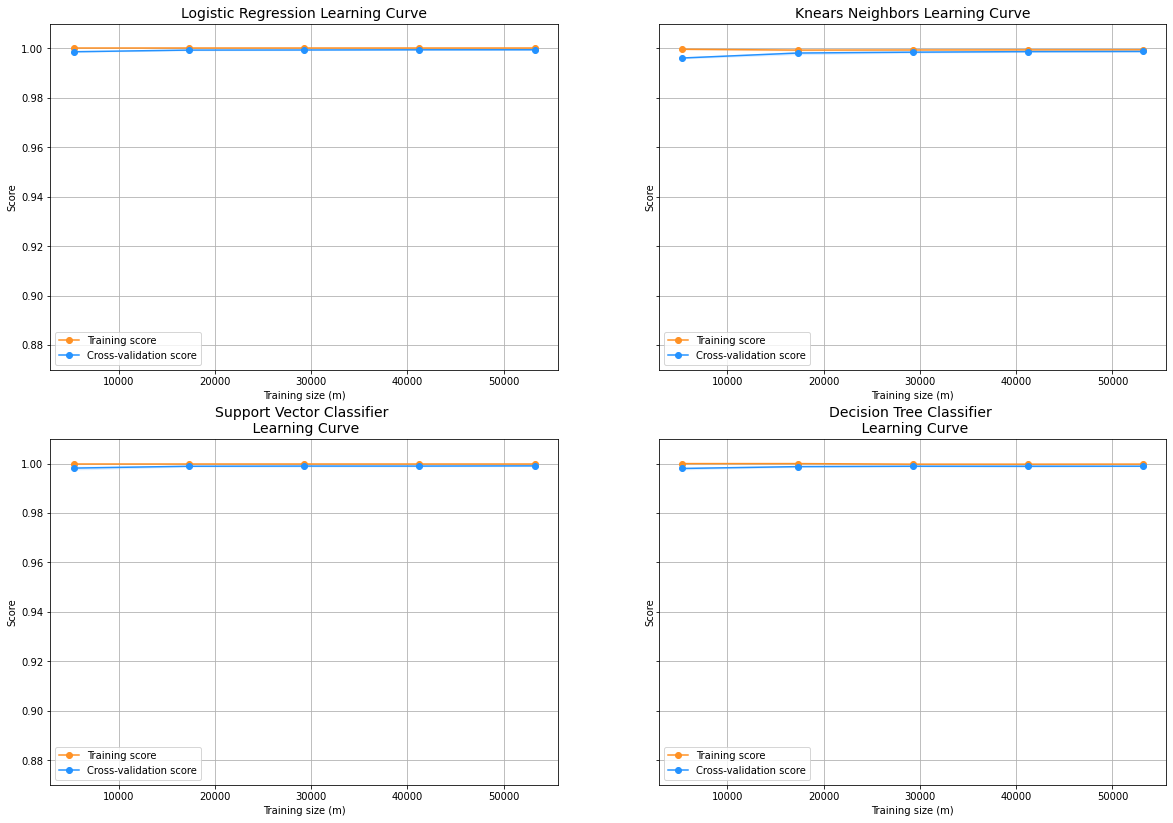

In [54]:
%%time
cl_rf=RandomForestClassifier()
cl_kn=KNeighborsClassifier()
cl_sv=SVC()
cl_dt=DecisionTreeClassifier()
cl_ada=AdaBoostClassifier()
cl_grbo=GradientBoostingClassifier()
cv=3
plot_learning_curve(cl_rf,cl_sv,cl_dt,cl_grbo, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=1)